## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model_classes import HealthModel
import torch
from datetime import datetime as dt

## Config

Linear regressor config:

In [139]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "val_size": False, # Set MLP 
    "hidden_layer_sizes": False, # configs
    "batch_size": False, # to False
    "num_epochs": False, # if using
    "learning_rate": False, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "wind_dir", "pressure"], # Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", "property_income_paid", 
                         "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": ["temperature"], # Set to False if not analysis feature importance
    "target_shift": 0 # Time lag for target variable
    }

MLP regressor config:

In [11]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_sizes": [10],
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "wind_dir", "pressure"], # Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", "property_income_paid",
                         "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": ["PM10"], # Set to False if not analysis feature importance
    "target_shift": 1 # Time lag for target variable
    }

torch.manual_seed(1)

In [12]:
if not config["ablation_features"]:
    plot_title_model = f"(all inputs, time lag {config['target_shift']})"
else:
    plot_title_model = f"(excluding {', '.join(config['ablation_features'])}, time lag {config['target_shift']})"

## Code

In [13]:
model = HealthModel(config)

In [14]:
df = model.preprocess_and_log()

laqn-regional


wandb:   6 of 6 files downloaded.  


met-resample


wandb:   8 of 8 files downloaded.  


income-regional


wandb:   51 of 51 files downloaded.  


Index(['NO2_mean', 'NO2_min', 'NO2_max', 'PM10_mean', 'PM10_max', 'PM10_min',
       'temperature_mean', 'temperature_min', 'temperature_max',
       'humidity_mean', 'humidity_min', 'humidity_max', 'dew_point_mean',
       'dew_point_min', 'dew_point_max', 'wind_speed_mean', 'wind_speed_min',
       'wind_speed_max', 'wind_dir_mean', 'wind_dir_min', 'wind_dir_max',
       'pressure_mean', 'pressure_min', 'pressure_max',
       'gross_disposable_income_min', 'gross_disposable_income_median',
       'gross_disposable_income_max', 'property_income_received_max',
       'property_income_received_median', 'property_income_received_min',
       'property_income_paid_median', 'property_income_paid_max',
       'property_income_paid_min', 'social_benefits_received_median',
       'social_benefits_received_max', 'social_benefits_received_min',
       'current_taxes_on_wealth_median', 'current_taxes_on_wealth_max',
       'current_taxes_on_wealth_min'],
      dtype='object')
Ablation - scramble

wandb:   1 of 1 files downloaded.  


In [54]:
# print(df.columns)
# print(len(df.columns))

In [55]:
# df[["NO2_max", "NO2_mean", "NO2_min"]].plot(alpha=0.7)
# df[["PM10_max", "PM10_mean", "PM10_min"]].plot(alpha=0.7)

# df[["temperature_max", "temperature_mean", "temperature_min"]].plot(alpha=0.7)
# df[["humidity_max", "humidity_mean", "humidity_min"]].plot(alpha=0.7)
# df[["dew_point_max", "dew_point_mean", "dew_point_min"]].plot(alpha=0.7)
# df[["pressure_max", "pressure_mean", "pressure_min"]].plot(alpha=0.7)
# df[["wind_speed_max", "wind_speed_mean", "wind_speed_min"]].plot(alpha=0.7)
# df[["wind_dir_max", "wind_dir_mean", "wind_dir_min"]].plot(alpha=0.7)

In [142]:
print(f"Time lag: {config['target_shift']}")
model.create_baseline()

Time lag: 30


wandb:   1 of 1 files downloaded.  


baseline_mean_absolute_percentage_error,▁
baseline_mean_squared_error,▁
baseline_r_squared,▁
baseline_root_mean_squared_error,▁
baseline_symmetric_mean_absolute_percentage_error,▁
baseline_mean_absolute_percentage_error,12.42662
baseline_mean_squared_error,0.05992
baseline_r_squared,-0.21198
baseline_root_mean_squared_error,0.24478
baseline_symmetric_mean_absolute_percentage_error,12.29322


In [15]:
model.train_and_log()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


best_epoch,▁
best_mean_absolute_percentage_error_train,▁
best_mean_absolute_percentage_error_val,▁
best_mean_squared_error_train,▁
best_mean_squared_error_val,▁
best_r_squared_train,▁
best_r_squared_val,▁
best_rmse_train,▁
best_rmse_val,▁
best_smape_train,▁
best_smape_val,▁


In [16]:
data_dict = model.test_and_log()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


mean_absolute_percentage_error_test,▁
mean_squared_error_test,▁
r2_test,▁
rmse_test,▁
smape_test,▁
mean_absolute_percentage_error_test,9.39474
mean_squared_error_test,0.04085
r2_test,0.28689
rmse_test,0.20211
smape_test,9.64854


#### Alternative
If the model has already been run, lookup the test_and_log output artifact version on the wandb web interface and read it in here:

In [17]:
#data_dict = model.read_data("xy_all", "v2") 

## Plot results

In [18]:
df = pd.DataFrame()
subsets = ["train", "val", "test"] if config["val_size"] else ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"], "predicted":data_dict[f"y_{subset}_predict"]})
    df = subset_df.copy() if df.empty else df.append(subset_df)

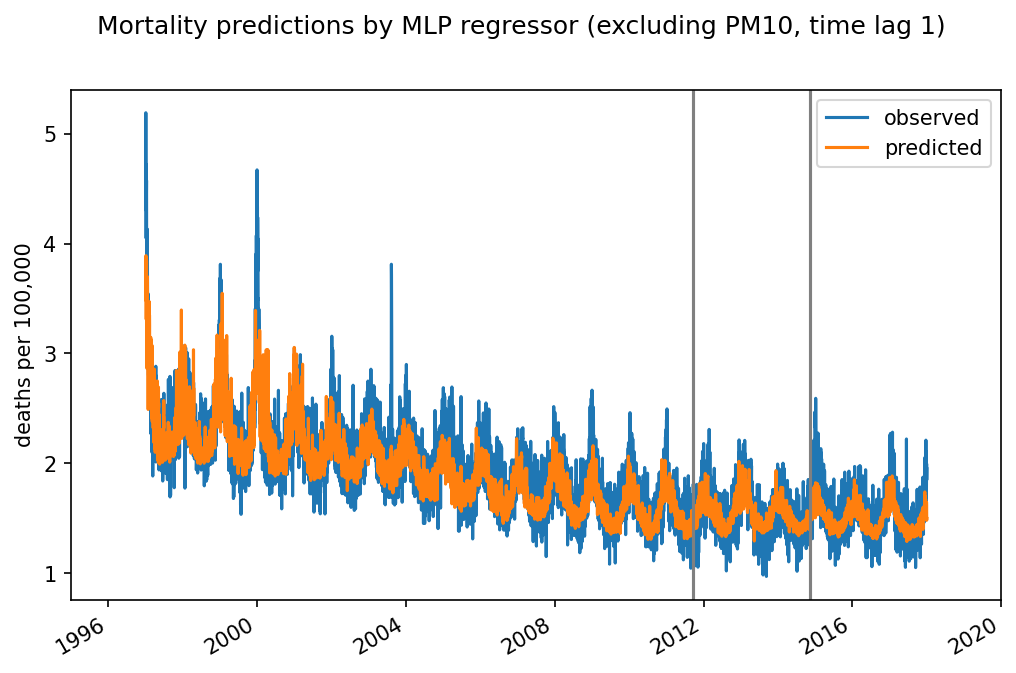

In [19]:
plt.figure(figsize=(8,5), dpi=150)
df["observed"].plot()
df["predicted"].plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
plt.axvline(data_dict["val_dates"].max(), color="grey") if config["val_size"] else None
plt.legend()
plt.ylabel("deaths per 100,000")
plt.xlim(dt(year=1995, month=1, day=1), dt(year=2020, month=1, day=1))
regressor_title = config["architecture"].replace("_", " ")
plt.suptitle(f"Mortality predictions by {regressor_title} {plot_title_model}")
plt.show()